In [1]:
#!pip -q install /pstore/home/shetabs1/code/iflai/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [3]:
from scifAI.dl.utils import train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics

In [4]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [5]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [6]:
from sklearn.random_projection import GaussianRandomProjection

In [7]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [8]:
metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")
metadata

/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [9]:
metadata.set.unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [10]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

In [11]:
set_of_interesting_classes = ['B_cell',  
                              'T_cell', 
                              'T_cell_with_signaling',
                              'T_cell_with_B_cell_fragments',
                              'B_T_cell_in_one_layer',
                              'Synapses_without_signaling', 
                              'Synapses_with_signaling',
                              'No_cell_cell_interaction',
                              'Multiplets']

In [12]:
metadata["set"].unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [13]:
unlabeled_index = metadata["set"] == "unlabeled"
unlabeled_index = unlabeled_index[unlabeled_index].index

 
labeled_index = metadata["label"].isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & labeled_index
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & labeled_index
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & labeled_index
test_index = test_index[test_index].index

In [14]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1

print("Number of labeled images",labeled_index.sum())

Number of labeled images 5221


In [15]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [16]:
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

In [17]:
reshape_size = 160
selected_channels = [0,3,4,5,6]

stats = dict()

stats["lower_bound"] = torch.tensor([756.5198,52.5891,45.7574,54.1436,39.0545])
stats["upper_bound"] = torch.tensor([835.3564,288.1139,271.3861,234.2525,90.0396])

In [18]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [19]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [20]:
import torch.nn as nn
from torchvision.models import resnet152, resnet18, resnet34, resnet50
import torch.nn.functional as F

class ResNet34Modified(nn.Module):
    def __init__(self,  num_channels=3, num_classes=3, pretrained=True, progress=True, **kwargs):
        super().__init__()
        model = resnet34(pretrained=pretrained)
        if num_channels != 3:
            model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = model

    def forward(self, x):                
        return self.model(x)

In [21]:
resnet34_modified = ResNet34Modified(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

In [22]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.05),
])



train_dataset = DatasetGenerator(metadata.loc[train_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                 scaling_factor = 1.,
                                label_map=label_map, 
                                 transform = train_transform,
                                selected_channels=selected_channels)

In [23]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

tensor(6)


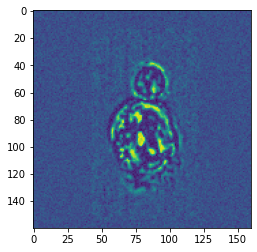

In [24]:
i = 40
plt.imshow(train_dataset[i][0][0,:,:])
print(train_dataset[i][1])

In [25]:
validation_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

test_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
])

validation_dataset = DatasetGenerator(metadata.loc[validation_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                 scaling_factor = 1.,
                                transform=validation_transforms, 
                                selected_channels=selected_channels)

test_dataset = DatasetGenerator(metadata.loc[test_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                 scaling_factor = 1.,
                                transform=test_transforms, 
                                selected_channels=selected_channels)

In [26]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)
#checkpoint = Checkpoint(f_params='resnet_18_imagenet_pretraiend_supervised_learning.pth', monitor='valid_f1_macro')

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

model = NeuralNetClassifier(    
    resnet34_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    batch_size=32,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=5,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=1,
    callbacks=[lr_scheduler,epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [27]:
model = model.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        2.3701       0.4104            0.3151        2.3753  12.0172
      2        1.3124       0.4925            0.3847        1.8474  11.7211
      3        1.1060       0.6142            0.5640        0.9900  11.5118
      4        0.9430       0.5732            0.5054        1.3244  11.5531
      5        0.8448       0.5964            0.5215        0.9096  11.5861
      6        0.8091       0.6881            0.6684        0.8424  11.5008
      7        0.7611       0.6648            0.6252        0.8433  11.5119
      8        0.6992       0.6389            0.6290        0.9896  11.5441
      9        0.6564       0.7264            0.7200        0.7028  11.5270
     10        0.6255       0.7360            0.7367        0.6292  11.5625
     11        0.5999       0.7360            0.7317        0.6862  11.5680
     12     

     95        0.1802       0.8769            0.8749        0.3521  11.5563
     96        0.1839       0.8865            0.8831        0.3712  11.5500
     97        0.1671       0.8988            0.8969        0.3266  11.4948
     98        0.1681       0.8960            0.8922        0.3183  11.6106
     99        0.1851       0.9042            0.9002        0.3482  11.5641
    100        0.1628       0.8865            0.8834        0.3768  11.5656
    101        0.1853       0.8906            0.8875        0.3442  11.5820
    102        0.1655       0.8824            0.8800        0.3649  11.5697
    103        0.1943       0.9056            0.9024        0.3373  11.6012
    104        0.1516       0.8933            0.8907        0.3715  11.5358
    105        0.1469       0.9015            0.8981        0.3592  11.5368
    106        0.1826       0.8810            0.8789        0.4196  11.6070
    107        0.1916       0.9070            0.9040        0.3545  11.6403
    108     

    198        0.0387       0.9015            0.8976        0.4745  11.5542
    199        0.0443       0.8988            0.8951        0.4838  11.5637
    200        0.0390       0.8947            0.8910        0.5040  11.5768
    201        0.0457       0.9001            0.8975        0.4872  11.5798
    202        0.0471       0.8974            0.8946        0.5018  11.5585
    203        0.0431       0.9070            0.9033        0.4455  11.5624
    204        0.0463       0.9001            0.8973        0.4589  11.6052
    205        0.0465       0.8892            0.8854        0.4757  11.5412
Stopping since valid_f1_macro has not improved in the last 50 epochs.


In [28]:
#model.module.load_state_dict(torch.load('resnet_18_imagenet_pretraiend_supervised_learning.pth')) 


In [29]:
## START from here

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        89
           1       0.92      0.97      0.94        94
           2       0.94      0.87      0.90        70
           3       0.86      0.95      0.90        88
           4       0.90      0.74      0.81        74
           5       0.75      0.78      0.77        69
           6       0.87      0.87      0.87        94
           7       0.89      0.88      0.88        82
           8       0.96      0.93      0.94        71

    accuracy                           0.89       731
   macro avg       0.89      0.89      0.89       731
weighted avg       0.90      0.89      0.89       731

------------------------------------------------------------
matthews correlation coeff: 0.8815
Cohen Kappa score: 0.8812
Accuracy: 0.8947 & balanced Accuracy: 0.8889
macro F1 score: 0.8903 & micro F1 score: 0.8947
macro Precision score: 0.8946 & micro Precision score: 0.8947
macro Recall score

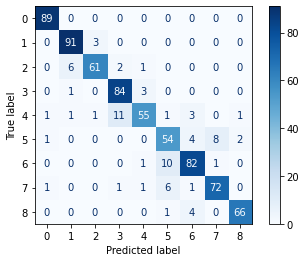

------------------------------------------------------------


In [30]:
preds = model.predict(validation_dataset)

classification_complete_report([label_map[t] for t in validation_dataset.metadata.label], 
                               preds  )

In [31]:
set_of_interesting_classes

['B_cell',
 'T_cell',
 'T_cell_with_signaling',
 'T_cell_with_B_cell_fragments',
 'B_T_cell_in_one_layer',
 'Synapses_without_signaling',
 'Synapses_with_signaling',
 'No_cell_cell_interaction',
 'Multiplets']

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       190
           1       0.94      0.94      0.94       200
           2       0.94      0.87      0.91       148
           3       0.88      0.94      0.91       189
           4       0.88      0.88      0.88       161
           5       0.80      0.90      0.84       147
           6       0.88      0.86      0.87       196
           7       0.96      0.96      0.96       182
           8       0.98      0.84      0.90       154

    accuracy                           0.91      1567
   macro avg       0.91      0.91      0.91      1567
weighted avg       0.92      0.91      0.91      1567

------------------------------------------------------------
matthews correlation coeff: 0.9024
Cohen Kappa score: 0.9022
Accuracy: 0.9132 & balanced Accuracy: 0.9098
macro F1 score: 0.9108 & micro F1 score: 0.9132
macro Precision score: 0.9142 & micro Precision score: 0.9132
macro Recall score

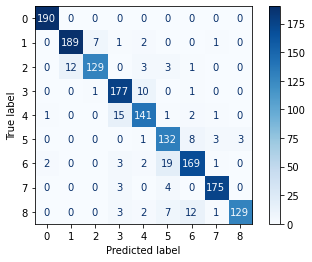

------------------------------------------------------------


In [32]:
preds = model.predict(test_dataset)

classification_complete_report([label_map[t] for t in test_dataset.metadata.label],  preds   )

## saving the results

In [33]:
preds = pd.Series(preds).to_csv("resnet34_preds.csv")